### Final Project: Analyzing Hate Speech

For this project we will suppose the author is a data scientist working on behalf of a Vietnamese government stakeholder interested in curtailing online harassment. Follow along as we walk through the process of defining and isolating hate speech

### Business Background

Since the beginning of the modern internet...

In [323]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, words, wordnet
import string
nltk.download('words')
nltk.download('stopwords', quiet=True)
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('tagsets')
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, precision_score, classification_report
from sklearn import svm

#Ignore warnings
import warnings

[nltk_data] Downloading package words to
[nltk_data]     /Users/russellblanchard/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/russellblanchard/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/russellblanchard/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


### Data Exploration

In [324]:
df = pd.read_csv('vihsd/data/vihsd/dev.csv')
df_train = pd.read_csv('vihsd/data/vihsd/train.csv')
df_test = pd.read_csv('vihsd/data/vihsd/test.csv')

In [325]:
! pwd


/Users/russellblanchard/Documents/Flatiron/DS-NATL-010923


In [326]:
! ls


CodeChallengePhase1                    Untitled1.ipynb
NLPCheckPoint                          checkpoints
NLPCheckPoint.zip                      dsc-arma-models-statsmodels-lab
PSRproject2                            dsc-code-challenge-4-cg
Phase1                                 dsc-data-serialization-lab
Phase2                                 dsc-linear-regression-lab
Phase2CodeChallenge                    dsc-market-segmentation-clustering-lab
Phase3                                 dsc-pandas-eda-lab
Phase3CodeChallenge                    dsc-phase-1-project-v2-4
Phase3project.ipynb                    dsc-project-template
Phase4                                 finalproject.ipynb
Phase4NLP                              index (4).ipynb
README.md                              telecomchurndata.csv
Untitled.ipynb                         vihsd


In [327]:
! ls vihsd


README.md                             ViHSD_multilingual_Transformers.ipynb
ViHSD_DNN.ipynb                       data
ViHSD_monolingual_Transformers.ipynb


In [328]:
! ls vihsd/data/vihsd


dev.csv   test.csv  train.csv


Datasets provided by source material : 
@InProceedings{10.1007/978-3-030-79457-6_35,
author="Luu, Son T.
and Nguyen, Kiet Van
and Nguyen, Ngan Luu-Thuy",
editor="Fujita, Hamido
and Selamat, Ali
and Lin, Jerry Chun-Wei
and Ali, Moonis",
title="A Large-Scale Dataset for Hate Speech Detection on Vietnamese Social Media Texts",
booktitle="Advances and Trends in Artificial Intelligence. Artificial Intelligence Practices",
year="2021",
publisher="Springer International Publishing",
address="Cham",
pages="415--426",
abstract="In recent years, Vietnam witnesses the mass development of social network users on different social platforms such as Facebook, Youtube, Instagram, and Tiktok. On social media, hate speech has become a critical problem for social network users. To solve this problem, we introduce the ViHSD - a human-annotated dataset for automatically detecting hate speech on the social network. This dataset contains over 30,000 comments, each comment in the dataset has one of three labels: CLEAN, OFFENSIVE, or HATE. Besides, we introduce the data creation process for annotating and evaluating the quality of the dataset. Finally, we evaluate the dataset by deep learning and transformer models.",
isbn="978-3-030-79457-6"
}

In [329]:
df.head()

,free_text,label_id
0,Coi cười xỉu,0
1,Chi ba vang ngoc dep va tre mai,0
2,"Chần vần một đống, không ai đoán trước được đừ...",0
3,Du học sinh Úc mà lại,0
4,Dm báo lá cải.. Nghĩ gì khi ở qn mà có hơn 30%...,0


In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   free_text  2672 non-null   object
 1   label_id   2672 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.9+ KB


In [331]:
df.shape

(2672, 2)

In [332]:
df['label_id'].value_counts()

0    2190
2     270
1     212
Name: label_id, dtype: int64

In [333]:
df['label_id'].value_counts(normalize=True)

0    0.819611
2    0.101048
1    0.079341
Name: label_id, dtype: float64

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

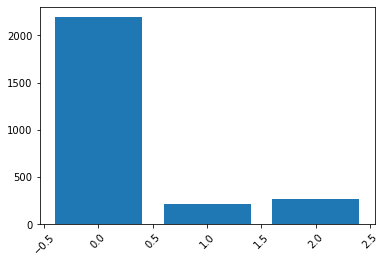

In [334]:
plt.bar(df['label_id'].value_counts().index, df['label_id'].value_counts().values)
plt.xticks(rotation=45)

This data is heavily imbalanced towards 'clean' or inoffensive speech, but relatively balanced between the offensive and hate categories

### Cleaning Data

First we remove any blank comments

In [335]:
df.dropna()

,free_text,label_id
0,Coi cười xỉu,0
1,Chi ba vang ngoc dep va tre mai,0
2,"Chần vần một đống, không ai đoán trước được đừ...",0
3,Du học sinh Úc mà lại,0
4,Dm báo lá cải.. Nghĩ gì khi ở qn mà có hơn 30%...,0
...,...,...
2667,Thật sự là đã hi sinh quá nhiều,0
2668,chật chội vậy cơ mà,0
2669,Chống dịch như chống giặc,0
2670,Bao nhiêu ae ra đảo giờ chưa về hôm bữa theo 1...,0


Now we're going to remove the inoffensive comments to focus solely on the offensive and hate categoreies

In [336]:
df = df[(df['label_id'] != 0)]

In [337]:
df.shape

(482, 2)

In [338]:
df.tail()

,free_text,label_id
2656,Ngu thì làm mất kệ cmn,2
2658,"Một đám dlv tư chịch vs nhau, tởm vkl",2
2662,Nghĩa Le sân si hả má ?? Ko thích coi thì cút ...,2
2666,Nay toàn lấy cơ chơi lễ trung thu để đi địt nh...,1
2671,Dcm ăn pải lốp lái thì giết con nhà ng ta ah c...,2


Here we convert the column names

In [339]:
df.set_axis(['comment', 'hateful'], axis=1, inplace=True)

In [340]:
df.head()

,comment,hateful
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,2
21,chậm cái địt mẹ m,2
27,Ảnh ghép hú hồn cái lol còn nguyên 🤧🤧,1
35,Lý Thành Công phục cái máu lồn,1
38,Cánh hoa gì lạ l.o.n zị nè Nguyễn Mỹ Diễm,2


Now we subtract each column by one to convert to boolean

In [341]:
df['hateful'] = df['hateful'] - 1

In [342]:
df.head()

,comment,hateful
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,1
21,chậm cái địt mẹ m,1
27,Ảnh ghép hú hồn cái lol còn nguyên 🤧🤧,0
35,Lý Thành Công phục cái máu lồn,0
38,Cánh hoa gì lạ l.o.n zị nè Nguyễn Mỹ Diễm,1


### Final dataframe

In [343]:
df['hateful'] = df['hateful'].astype(bool)
df.head()

,comment,hateful
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,True
21,chậm cái địt mẹ m,True
27,Ảnh ghép hú hồn cái lol còn nguyên 🤧🤧,False
35,Lý Thành Công phục cái máu lồn,False
38,Cánh hoa gì lạ l.o.n zị nè Nguyễn Mỹ Diễm,True


### Preprocessing

Here we are going to further prepare our data for making our models by finding the most common phrases in both the offensive and hateful categories so we can use them to predict the accuracy of the hatefulness status

In [344]:
words = Counter()

for tweet in df['comment']:
    tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
    tokenized = tokenizer.tokenize(tweet)
    for token in tokenized:
        words[token] += 1

In [345]:
test_words = words.most_common()[10:20]
print(test_words)

[('đi', 45), ('cũng', 45), ('như', 44), ('ra', 42), ('rồi', 41), ('ko', 40), ('nói', 39), ('làm', 39), ('không', 38), ('của', 37)]


Due to the lack of automated translation only the first 10 words could be translated and were eliminated as most were consonants. Instead we're working with the 10 most common words following that for the list

### Train Test Split

Although we've been generously given a train and a test by the original researchers, to avoid data leakage we are generating our own here. 

In [346]:
X = pd.DataFrame(df['comment'])
y = pd.DataFrame(df['hateful'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### First Simple Model

Linear regression

In [347]:
#linear regression

### Baseline Model

Logistic Regression

In [348]:
#logistic regression

### Second Model

naive bayes

In [349]:
#naive bayes

### Model Comparison